# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [0]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week6()

--2019-06-08 09:02:50--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2019-06-08 09:02:50 (67.1 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]

**************************************************
captions_train-val2014.zip
**************************************************
train2014_sample.zip
**************************************************
train_img_embeds.pickle
**************************************************
train_img_fns.pickle
**************************************************
val2014_sample.zip
*******************************

In [0]:
import sys
sys.path.append("..")
import grading
import download_utils

In [0]:
download_utils.link_all_keras_resources()

In [0]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils
from  collections import Counter

# Prepare the storage for model checkpoints

In [0]:
# Leave USE_GOOGLE_DRIVE = False if you're running locally!
# We recommend to set USE_GOOGLE_DRIVE = True in Google Colab!
# If set to True, we will mount Google Drive, so that you can restore your checkpoint 
# and continue trainig even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
USE_GOOGLE_DRIVE = True

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab/weights_10


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [0]:
grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [0]:
# token expires every 30 min
COURSERA_TOKEN = "yIzqvZ7TXDHegSq4"
COURSERA_EMAIL = "poul.shabarkin@gmail.com"

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [0]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/inceptionv3.png?raw=1" style="width:70%">

In [0]:
IMG_SIZE = 299

In [0]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [0]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [0]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

# Extract captions for images

In [0]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


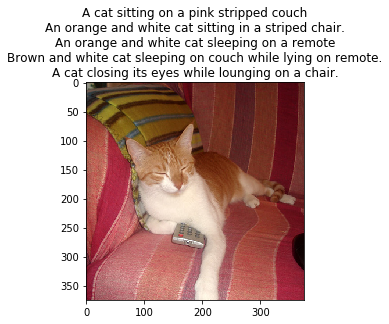

In [0]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [0]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [0]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """

    arr = np.array(train_captions).ravel()
    l_captions = []
    l_captions.extend([ word  for caption in arr for sentence in caption for word in split_sentence(sentence)] )
    

    
    vocab = []
    temp = dict(Counter(l_captions))
    filtered_temp = { x : temp[x] for x in temp if temp[x] >= 5}
    vocab = list(filtered_temp.keys())
    vocab.extend([PAD,START,UNK,END])
    
    return {token: index for index, token in enumerate(sorted(vocab))}
  
  
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    tokens_captions = []
    
    for image in captions:
      temp_caption = []
      for caption in image:
        
        temp_caption.append( [vocab[START]] + [vocab[i] if i in vocab.keys() else vocab[UNK] for i in split_sentence(str(caption))] + [vocab[END]])
      tokens_captions.append(temp_caption)
        
    print(captions[2])
    
    print(tokens_captions[2])

    return tokens_captions

In [0]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [0]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

['A tabby cat sitting in front of a car.', 'A brown and black cat sitting on driveway next to a white car.', 'A sleepy looking cat sitting in front of a white car.', 'A cat sits in front of a parked car.', 'A cat sitting in front of a parked white car.  ']
[[2, 54, 7643, 1288, 6888, 3885, 3175, 5127, 54, 1227, 0], [2, 54, 1002, 249, 777, 1288, 6888, 5155, 2476, 5025, 7905, 54, 8568, 1227, 0], [2, 54, 6969, 4470, 1288, 6888, 3885, 3175, 5127, 54, 8568, 1227, 0], [2, 54, 1288, 6885, 3885, 3175, 5127, 54, 5387, 1227, 0], [2, 54, 1288, 6888, 3885, 3175, 5127, 54, 5387, 8568, 1227, 0]]
['A teddy bear sits among a stereo system and a number of records.', 'A cluttered shelf with a stereo, book and a teddy bear.', 'A view of a teddy bear sitting in a chair in a play room. ', 'The stuffed teddy bear is underneath a stereo system. ', "A cluttered bookshelf with children's books and a teddybear. "]
[[2, 54, 7743, 656, 6885, 233, 54, 7354, 7639, 249, 54, 5072, 5127, 6173, 0], [2, 54, 1586, 6739, 8

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [0]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    

    if max_len == None:
      columns = max(map(len,batch_captions))
     
    else:
      columns = min(max_len, max(map(len,batch_captions)))


    matrix = np.empty((len(batch_captions),columns),dtype = type(pad_idx))
    matrix.fill(pad_idx)

    
    for idx in range(len(batch_captions)):  

      
      if max_len != None:
          if max_len < len(batch_captions[idx]):
            
            matrix[idx] = batch_captions[idx][:columns]
            
          else:
            matrix[idx,:len(batch_captions[idx])] = batch_captions[idx]
            
      else:
        matrix[idx,:len(batch_captions[idx])] = batch_captions[idx]

    return matrix

In [0]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [0]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

['A tabby cat sitting in front of a car.', 'A brown and black cat sitting on driveway next to a white car.', 'A sleepy looking cat sitting in front of a white car.', 'A cat sits in front of a parked car.', 'A cat sitting in front of a parked white car.  ']
[[2, 54, 7643, 1288, 6888, 3885, 3175, 5127, 54, 1227, 0], [2, 54, 1002, 249, 777, 1288, 6888, 5155, 2476, 5025, 7905, 54, 8568, 1227, 0], [2, 54, 6969, 4470, 1288, 6888, 3885, 3175, 5127, 54, 8568, 1227, 0], [2, 54, 1288, 6885, 3885, 3175, 5127, 54, 5387, 1227, 0], [2, 54, 1288, 6888, 3885, 3175, 5127, 54, 5387, 8568, 1227, 0]]
['A tabby cat sitting in front of a car.', 'A brown and black cat sitting on driveway next to a white car.', 'A sleepy looking cat sitting in front of a white car.', 'A cat sits in front of a parked car.', 'A cat sitting in front of a parked white car.  ']
[[2, 54, 7643, 1288, 6888, 3885, 3175, 5127, 54, 1227, 0], [2, 54, 1002, 249, 777, 1288, 6888, 5155, 2476, 5025, 7905, 54, 8568, 1227, 0], [2, 54, 6969, 44

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder_explained.png?raw=1" style="width:50%">

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/flatten_help.jpg?raw=1" style="width:80%">

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds)) ### YOUR CODE HERE ###

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds =word_embed(sentences[:,:-1]) ### YOUR CODE HERE ###
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states =tf.reshape(hidden_states,[-1,LSTM_UNITS]) ### YOUR CODE HERE ###

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth =tf.reshape(sentences[:, 1:], [-1,]) ### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx) ### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss =  tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask)) ### YOUR CODE HERE ###
   

In [0]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """


                   
      
      
    def get_random_caption(captions):
        return captions[random.sample(range(len(captions)), 1)[0]]
    
    batch_choice = random.sample(range(images_embeddings.shape[0]), batch_size)
    
    batch_image_embeddings = [images_embeddings[image_id] for image_id in batch_choice]
    
    batch_captions_matrix = batch_captions_to_matrix([get_random_caption(indexed_captions[image_id]) for image_id in batch_choice], pad_idx, max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
def get_random_caption(captions):
        return captions[random.sample(range(len(captions)), 1)[0]]
    
    batch_choice = random.sample(range(images_embeddings.shape[0]), batch_size)
    
    batch_image_embeddings = [images_embeddings[image_id] for image_id in batch_choice]
    
    batch_captions_matrix = batch_captions_to_matrix([get_random_caption(indexed_captions[image_id]) for image_id in batch_choice], pad_idx, max_len)

In [0]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [0]:
# you can load trained weights here
# uncomment the next line if you need to load weights
#saver.restore(s, get_checkpoint_path(epoch=4))

Look at the training and validation loss, they should be decreasing!

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, train_captions_indexed,  batch_size, MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 4.278284
Epoch: 0, train loss: 4.278283823013306, val loss: 3.702850341796875
**************************************************
Training loss: 3.362637
Epoch: 1, train loss: 3.3626366047859193, val loss: 3.142318375110626
**************************************************
Training loss: 3.002492
Epoch: 2, train loss: 3.0024915263652803, val loss: 2.958332917690277
**************************************************
Training loss: 2.848045
Epoch: 3, train loss: 2.848044625520706, val loss: 2.82776255607605
**************************************************
Training loss: 2.754413
Epoch: 4, train loss: 2.754413151025772, val loss: 2.786036856174469
**************************************************
Training loss: 2.696866
Epoch: 5, train loss: 2.6968660519123078, val loss: 2.7111980962753295
Instructions for updating:
Use standard file APIs to delete files with this prefix.
*************************************************

In [0]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", grading_utils.test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************



In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [0]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.617395
Accuracy: 0.4778393351800554
Example 0
Predicted: a man sitting on a bench with a of a wooden covered field #END# #END# #END# #END# #END# #END#
Truth: a man sitting on a bench on top of a snow covered hill #END# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a living room with a walls and and and and a #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a living room with red accent wall television sofa and fireplace #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a men are on a train with has a on it #END# #END# #END# #END# #END# #END# #END# #END#
Truth: two people sitting at a table that has food on it #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [0]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/gdrive/My Drive/colab/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [0]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/colab/weights


In [0]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [0]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a small bird is sitting on a table


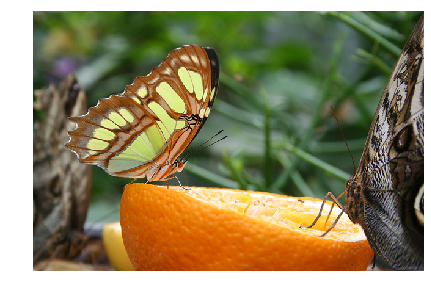

In [0]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=45)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


a clock tower with a clock on the top of it


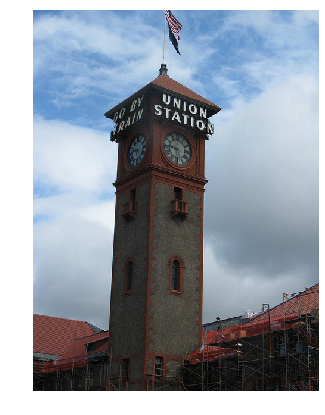

a man is playing a video game in a living room


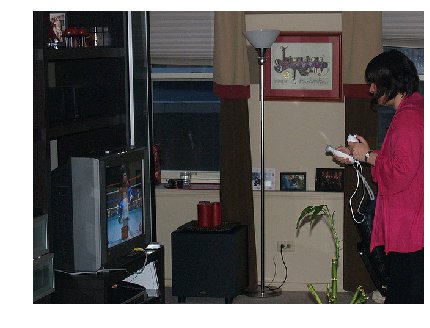

a beach with a kite flying in the air


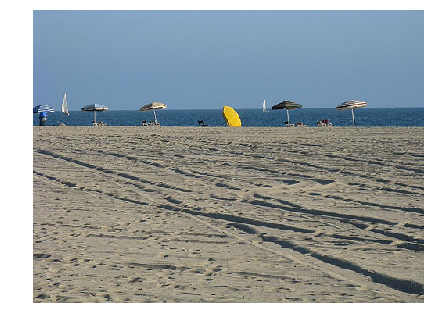

a close up of a bowl of fruit with a knife


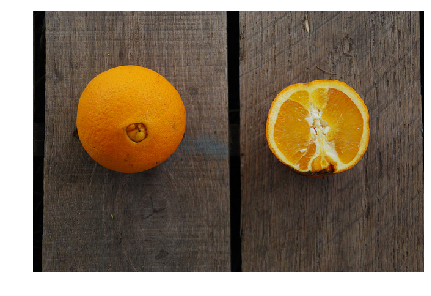

a man is running with a frisbee in his hand


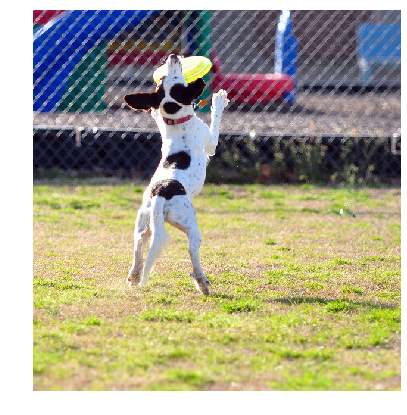

a double decker bus is parked in a parking lot


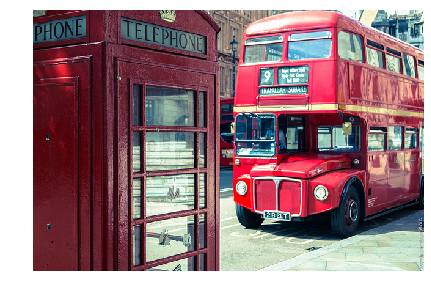

a man in a black shirt throwing a frisbee


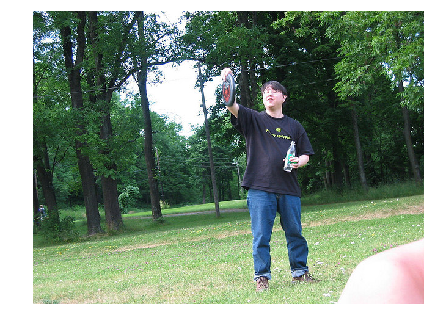

a table with a plate of food and a drink


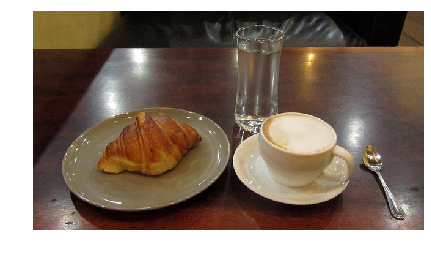

a man is jumping in the air catching a frisbee


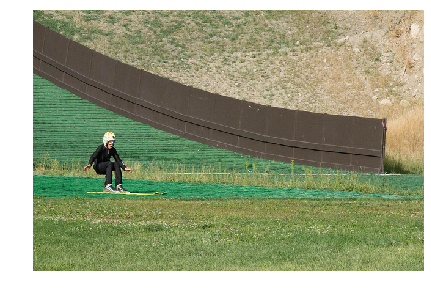

a bed with a bed and a bed with a red blanket


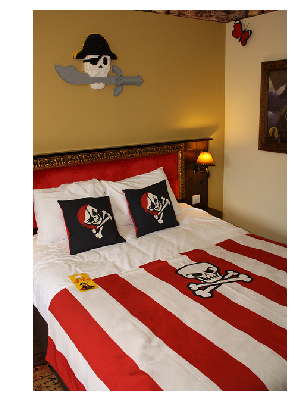

In [0]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)
    
    
    
      
      


You can download any image from the Internet and appply your model to it!

In [0]:
download_utils.download_file(
    "https://www.sdhsaa.com/Portals/0/ContentRotator/BoysTrackField.jpg",
    "BoysTrackField.jpg"
)

**************************************************
BoysTrackField.jpg


In [0]:
# not WORK
! wget "http://www.gifszone.com/content/layout/animal/animal_65.jpg"
apply_model_to_image_raw_bytes(open("animal_65.jpg", "rb").read())

! wget "http://www.gifszone.com/content/layout/animal/animal_64.jpg"
apply_model_to_image_raw_bytes(open("animal_64.jpg", "rb").read())

! wget "http://www.gifszone.com/content/layout/animal/animal_63.jpg"
apply_model_to_image_raw_bytes(open("animal_63.jpg", "rb").read())

! wget "http://www.gifszone.com/content/layout/animal/animal_62.jpg"
apply_model_to_image_raw_bytes(open("animal_62.jpg", "rb").read())

! wget "http://www.gifszone.com/content/layout/animal/animal_61.jpg"
apply_model_to_image_raw_bytes(open("animal_61.jpg", "rb").read())

! wget "http://www.gifszone.com/content/layout/animal/animal_66.jpg"
apply_model_to_image_raw_bytes(open("animal_66.jpg", "rb").read())

! wget "http://www.gifszone.com/content/layout/animal/animal_67.jpg"
apply_model_to_image_raw_bytes(open("animal_67.jpg", "rb").read())

! wget "http://www.gifszone.com/content/layout/animal/animal_68.jpg"
apply_model_to_image_raw_bytes(open("animal_68.jpg", "rb").read())

! wget "http://www.gifszone.com/content/layout/animal/animal_69.jpg"
apply_model_to_image_raw_bytes(open("animal_69.jpg", "rb").read())

! wget "http://www.gifszone.com/content/layout/animal/animal_70.jpg"
apply_model_to_image_raw_bytes(open("animal_70.jpg", "rb").read())



--2019-06-08 14:03:32--  https://thumbs.dreamstime.com/t/sportsman-cyclist-sportswear-helmet-riding-cross-country-bicycle-mountain-road-back-view-carpathian-mountains-blue-119848663.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.163.122
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.163.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7681 (7.5K) [image/jpeg]
Saving to: ‘sportsman-cyclist-sportswear-helmet-riding-cross-country-bicycle-mountain-road-back-view-carpathian-mountains-blue-119848663.jpg.10’

sportsman-cyclist-s 100%[===================>]   7.50K  --.-KB/s    in 0s      

2019-06-08 14:03:32 (358 MB/s) - ‘sportsman-cyclist-sportswear-helmet-riding-cross-country-bicycle-mountain-road-back-view-carpathian-mountains-blue-119848663.jpg.10’ saved [7681/7681]

a man riding a bike on a beach


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


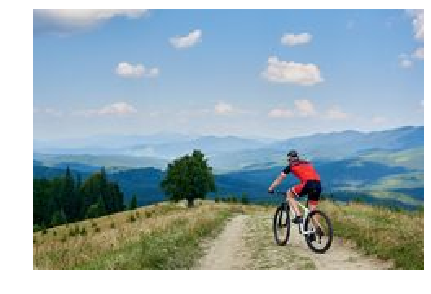

--2019-06-08 14:03:34--  https://www.salzburg.info/deskline/infrastruktur/objekte/gruenmarkt_4584/image-thumb__383__teaser--topic/gruenmarkt-in-salzburg_4586@2x.jpeg
Resolving www.salzburg.info (www.salzburg.info)... 80.123.168.151
Connecting to www.salzburg.info (www.salzburg.info)|80.123.168.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223842 (219K) [image/jpeg]
Saving to: ‘gruenmarkt-in-salzburg_4586@2x.jpeg.7’

gruenmarkt-in-salzb 100%[===================>] 218.60K   440KB/s    in 0.5s    

2019-06-08 14:03:35 (440 KB/s) - ‘gruenmarkt-in-salzburg_4586@2x.jpeg.7’ saved [223842/223842]

a woman is standing in front of a large table full of food


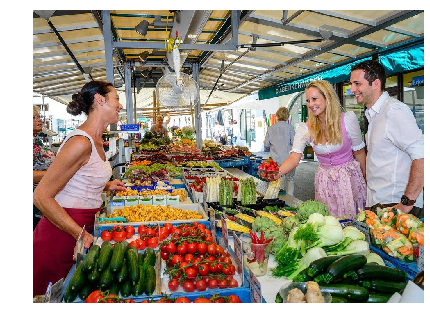

--2019-06-08 14:03:37--  https://media-public.canva.com/MADUu0BBNTI/1/thumbnail_large.jpg
Resolving media-public.canva.com (media-public.canva.com)... 104.16.77.22, 104.16.81.22, 104.16.78.22, ...
Connecting to media-public.canva.com (media-public.canva.com)|104.16.77.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42303 (41K) [image/jpeg]
Saving to: ‘thumbnail_large.jpg.6’

thumbnail_large.jpg 100%[===================>]  41.31K  --.-KB/s    in 0.01s   

2019-06-08 14:03:37 (3.45 MB/s) - ‘thumbnail_large.jpg.6’ saved [42303/42303]

a clock tower sitting on top of a building


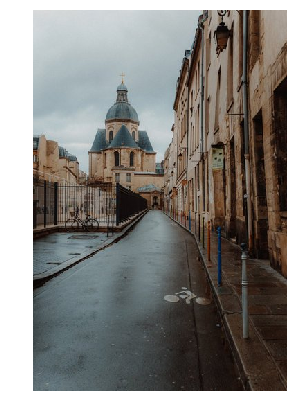

--2019-06-08 14:03:39--  https://files.brightside.me/files/news/part_22/223005/6210955-tumblr_n88dvaCpK91qbqem3o1_1280-650-5b3dcf6e15-1492175965.jpg
Resolving files.brightside.me (files.brightside.me)... 136.243.139.201, 88.99.223.7, 88.99.144.207, ...
Connecting to files.brightside.me (files.brightside.me)|136.243.139.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137246 (134K) [image/jpeg]
Saving to: ‘6210955-tumblr_n88dvaCpK91qbqem3o1_1280-650-5b3dcf6e15-1492175965.jpg.5’

6210955-tumblr_n88d 100%[===================>] 134.03K   404KB/s    in 0.3s    

2019-06-08 14:03:40 (404 KB/s) - ‘6210955-tumblr_n88dvaCpK91qbqem3o1_1280-650-5b3dcf6e15-1492175965.jpg.5’ saved [137246/137246]

a woman is sitting on a bed with a cat


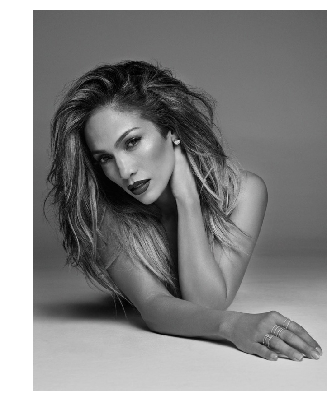

--2019-06-08 14:03:42--  https://nnimgt-a.akamaihd.net/transform/v1/crop/frm/pkEkn7P646fyiVKAd87Ha8/c5f2803e-b1fc-47ce-bd5f-053f8da8ef94.JPG/r1014_1440_3237_2765_w1200_h678_fmax.jpg
Resolving nnimgt-a.akamaihd.net (nnimgt-a.akamaihd.net)... 23.214.97.106, 23.214.97.72, 2600:1407:21::17d7:694b, ...
Connecting to nnimgt-a.akamaihd.net (nnimgt-a.akamaihd.net)|23.214.97.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114851 (112K) [image/jpeg]
Saving to: ‘r1014_1440_3237_2765_w1200_h678_fmax.jpg.2’

r1014_1440_3237_276 100%[===================>] 112.16K  --.-KB/s    in 0.01s   

2019-06-08 14:03:42 (7.38 MB/s) - ‘r1014_1440_3237_2765_w1200_h678_fmax.jpg.2’ saved [114851/114851]

a man in a green shirt is throwing a frisbee


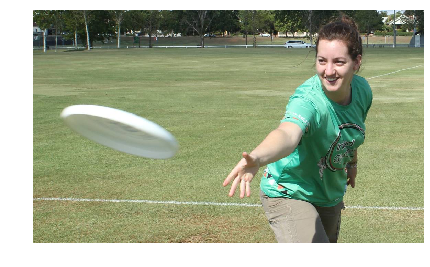

--2019-06-08 14:03:44--  https://cdn.citylab.com/media/img/citylab/2016/03/14276143663_8d760d6229_z/lead_large.jpg
Resolving cdn.citylab.com (cdn.citylab.com)... 151.101.186.133
Connecting to cdn.citylab.com (cdn.citylab.com)|151.101.186.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106728 (104K) [image/jpeg]
Saving to: ‘lead_large.jpg.5’

lead_large.jpg.5    100%[===================>] 104.23K  --.-KB/s    in 0.03s   

2019-06-08 14:03:44 (3.35 MB/s) - ‘lead_large.jpg.5’ saved [106728/106728]

a bus is driving down the street near a traffic light


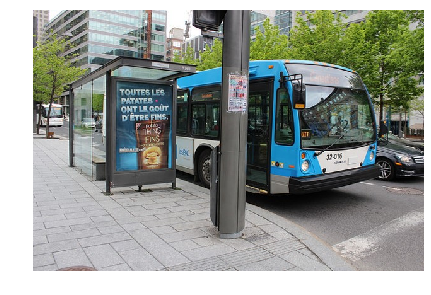

--2019-06-08 14:03:46--  https://www.capitalfm.co.ke/thesauce/files/2019/01/elephant.jpg
Resolving www.capitalfm.co.ke (www.capitalfm.co.ke)... 41.77.119.190
Connecting to www.capitalfm.co.ke (www.capitalfm.co.ke)|41.77.119.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150375 (147K) [image/jpeg]
Saving to: ‘elephant.jpg.3’

elephant.jpg.3      100%[===================>] 146.85K   891KB/s    in 0.2s    

2019-06-08 14:03:47 (891 KB/s) - ‘elephant.jpg.3’ saved [150375/150375]

an elephant is standing in the water


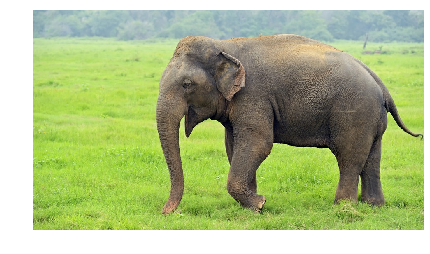

--2019-06-08 14:03:49--  http://footage.framepool.com/shotimg/283966414-sightseeing-bus-city-of-london-big-ben-double-decker-bus.jpg
Resolving footage.framepool.com (footage.framepool.com)... 208.111.171.216, 208.111.178.163
Connecting to footage.framepool.com (footage.framepool.com)|208.111.171.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35348 (35K) [image/jpeg]
Saving to: ‘283966414-sightseeing-bus-city-of-london-big-ben-double-decker-bus.jpg.4’

283966414-sightseei 100%[===================>]  34.52K  --.-KB/s    in 0.01s   

2019-06-08 14:03:49 (3.29 MB/s) - ‘283966414-sightseeing-bus-city-of-london-big-ben-double-decker-bus.jpg.4’ saved [35348/35348]

a large clock tower with a clock tower


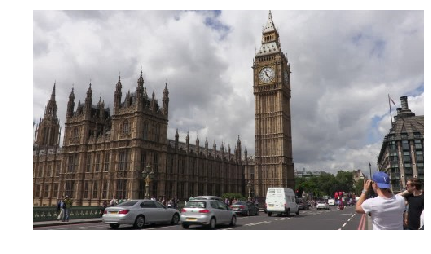

--2019-06-08 14:03:51--  http://assets.vogue.com/photos/58912fb9fb0604bf1f5c1629/master/pass/Hyo-Joo-Horizontal-Holding.jpg
Resolving assets.vogue.com (assets.vogue.com)... 151.101.0.239, 151.101.64.239, 151.101.128.239, ...
Connecting to assets.vogue.com (assets.vogue.com)|151.101.0.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463663 (453K) [image/jpeg]
Saving to: ‘Hyo-Joo-Horizontal-Holding.jpg.4’

Hyo-Joo-Horizontal- 100%[===================>] 452.80K  --.-KB/s    in 0.05s   

2019-06-08 14:03:51 (8.77 MB/s) - ‘Hyo-Joo-Horizontal-Holding.jpg.4’ saved [463663/463663]

a man riding a skateboard down a street


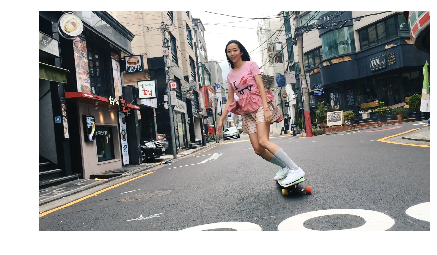

--2019-06-08 14:03:53--  https://image.shutterstock.com/display_pic_with_logo/136306/722718097/stock-photo-healthy-food-clean-eating-selection-fruit-vegetable-seeds-superfood-cereal-leaf-vegetable-on-722718097.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 173.223.148.35
Connecting to image.shutterstock.com (image.shutterstock.com)|173.223.148.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60102 (59K) [image/jpeg]
Saving to: ‘stock-photo-healthy-food-clean-eating-selection-fruit-vegetable-seeds-superfood-cereal-leaf-vegetable-on-722718097.jpg.4’

stock-photo-healthy 100%[===================>]  58.69K  --.-KB/s    in 0.03s   

2019-06-08 14:03:53 (2.09 MB/s) - ‘stock-photo-healthy-food-clean-eating-selection-fruit-vegetable-seeds-superfood-cereal-leaf-vegetable-on-722718097.jpg.4’ saved [60102/60102]

a table with a bunch of bananas and fruit


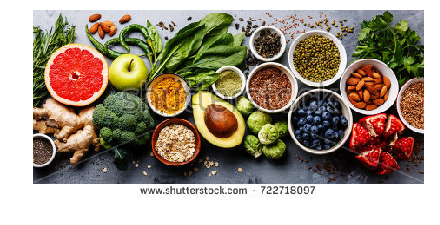

In [0]:
#  work
! wget "https://thumbs.dreamstime.com/t/sportsman-cyclist-sportswear-helmet-riding-cross-country-bicycle-mountain-road-back-view-carpathian-mountains-blue-119848663.jpg"
apply_model_to_image_raw_bytes(open("sportsman-cyclist-sportswear-helmet-riding-cross-country-bicycle-mountain-road-back-view-carpathian-mountains-blue-119848663.jpg", "rb").read())

! wget "https://www.salzburg.info/deskline/infrastruktur/objekte/gruenmarkt_4584/image-thumb__383__teaser--topic/gruenmarkt-in-salzburg_4586@2x.jpeg"
apply_model_to_image_raw_bytes(open("gruenmarkt-in-salzburg_4586@2x.jpeg", "rb").read())

! wget "https://media-public.canva.com/MADUu0BBNTI/1/thumbnail_large.jpg"
apply_model_to_image_raw_bytes(open("thumbnail_large.jpg", "rb").read())

! wget "https://files.brightside.me/files/news/part_22/223005/6210955-tumblr_n88dvaCpK91qbqem3o1_1280-650-5b3dcf6e15-1492175965.jpg"
apply_model_to_image_raw_bytes(open("6210955-tumblr_n88dvaCpK91qbqem3o1_1280-650-5b3dcf6e15-1492175965.jpg", "rb").read())


! wget "https://nnimgt-a.akamaihd.net/transform/v1/crop/frm/pkEkn7P646fyiVKAd87Ha8/c5f2803e-b1fc-47ce-bd5f-053f8da8ef94.JPG/r1014_1440_3237_2765_w1200_h678_fmax.jpg"
apply_model_to_image_raw_bytes(open("r1014_1440_3237_2765_w1200_h678_fmax.jpg", "rb").read())

! wget "https://cdn.citylab.com/media/img/citylab/2016/03/14276143663_8d760d6229_z/lead_large.jpg"
apply_model_to_image_raw_bytes(open("lead_large.jpg", "rb").read())

! wget "https://www.capitalfm.co.ke/thesauce/files/2019/01/elephant.jpg"
apply_model_to_image_raw_bytes(open("elephant.jpg", "rb").read())

! wget "http://footage.framepool.com/shotimg/283966414-sightseeing-bus-city-of-london-big-ben-double-decker-bus.jpg"
apply_model_to_image_raw_bytes(open("283966414-sightseeing-bus-city-of-london-big-ben-double-decker-bus.jpg", "rb").read())
! wget "http://assets.vogue.com/photos/58912fb9fb0604bf1f5c1629/master/pass/Hyo-Joo-Horizontal-Holding.jpg"
apply_model_to_image_raw_bytes(open("Hyo-Joo-Horizontal-Holding.jpg", "rb").read())

! wget "https://image.shutterstock.com/display_pic_with_logo/136306/722718097/stock-photo-healthy-food-clean-eating-selection-fruit-vegetable-seeds-superfood-cereal-leaf-vegetable-on-722718097.jpg"
apply_model_to_image_raw_bytes(open("stock-photo-healthy-food-clean-eating-selection-fruit-vegetable-seeds-superfood-cereal-leaf-vegetable-on-722718097.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!